# Gear Box Fault Detection

Gearbox Fault Diagnosis Data set include the vibration dataset recorded by using SpectraQuest’s Gearbox Fault Diagnostics Simulator. Dataset has been recorded with the help of 4 vibration sensors placed in four different direction. Data set has been recorded under variation of load from '0' to '90' percent. Data set has been recorded in two different scenario: 

1) Healthy condition and 

2) Broken Tooth Condition


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1  Load_data Function

Load_data function will load a text file in the data folder and will open as a Pandas DataFrame. The file can be in '.txt' or '.csv' extention file. This function developed to be used in the Join_table function. Input arguments for the function is 

- file_path = file name without the location of the file. Keep the files in the same directory of the python file. 

1. Set correct types for data to reduce memory usage.

### 2 Join_table funciton

Join_table function will load all the files present in the file list given as an argument and will concat them all as a pandas Dataframe. The only argument for this function is as follows :- 

- file_list = list of all the files to be loaded. All files extentions must be either ".txt" or ".csv"

### 3 Trimming function

Dataset consist of 10 files of faulty gearbox data and healty gearbox data each at different load percentage. Each of these files has different number of data points beacuse of the different time length of experiment. Hence, to make each load percentage experiment data of same length, we need to bring all the dataset at the same dimension. Hence, this function will select first 88200 data points from each file. 
$$ 294 \times 300 = 88200 $$

In [2]:
dfs = []
shapes = []
def Load_data(folder_path):
    dfs = pd.DataFrame()
    for dirname, _, filenames in os.walk(folder_path):
        for filename in filenames:
            
            # the gearbox state is in the filename prefix (h = healthy, b = broken tooth)
            state = filename[0]
            
            # the load is in the filename suffix
            load = int(filename.split('.')[0][5:])
            
            # read in the file
            df = pd.read_csv(os.path.join(dirname, filename))
            df.columns = ['S1', 'S2', 'S3', 'S4']
            
            # include the healthy/broken 0/1
            df['Fault'] = 0 if state == 'h' else 1
            df['Freq'] = 30 

            # include the load
            df['Load_percent'] = load 
            df = df[:88200]

            # append to a list
            dfs = pd.concat([dfs, df])
    # concatenate all the datasets and reset the index
    df = dfs.reset_index().drop(["index"], axis = 1)
    return df

def correct_datatype(data):
    data['S1'] = data['S1'].astype('float32')
    data['S2'] = data['S2'].astype('float32')
    data['S3'] = data['S3'].astype('float32')
    data['S4'] = data['S4'].astype('float32')
    data['Fault'] = data['Fault'].astype('int8')
    data['Freq'] = data['Freq'].astype('int8')
    data['Load_percent'] = data['Load_percent'].astype('int8')
    return data


### 4 Feature Creation from frequency domain dataset

The shape of the dataset after trimming is $(1764000, 7)$. The dataset shall be separate on the basis of fault, i.e. "Healthy" or "Broken". From this data, we have to create feature which shall be used to train our machine learning algorithms to predict the type of fault. To create the features, Feature_create function is used. This function uses various sub functions, which are as follows: - 

1) FFT : - FFT function is to convert a signal from time domain to frequency domain. This function takes an pandas Dataframe as an input argument and spit out an absolute value of FFT in Pandas Dataframe format. 

2) Concate_features : -  This function is the sub-function of the RMS function. It is used to rearrange the the RMS values of frequency of each sensor and rename the columns as $ S*_F@ $, where * is the sensor number and @ is frequency number (ranging from 1 to 15 Hz). 

3) RMS : - This function is responsible to take the RMS values of all the datapoint lies in the frequency bin of a single frequency. In this setting, each bin contains 10 datapoints. 


Using above mentioned functions, Feature_create function create the features for the given dataset. 
As an output, you get 60 features, 15 for each sensors. 

The logic of the function is as follows:- 

- Separate the data on the basis of load_percentage. Output should have 88200 rows. 

- A subset of 300 datapoints from the separated dataset is used for the FFT. Thus likewise, we get 294 chunks of subset. 

- This subset of dataset is used for FFT. 


In [3]:
## 4.1
import math
def FFT(data):
    col = data.columns.values
    df_fft = np.fft.fft(data, axis = 0)
    abs_df = pd.DataFrame(abs(df_fft), columns= col)
    
    return abs_df

In [4]:
## 4.2
def Concate_features(x):
    index_list = ["S" + str(n) for n in np.arange(1,5)]
    dff = pd.DataFrame({})
    for index in index_list:

        xx = x.loc[[index]]
        col = [index + "_" + "F" + str(n) for n in np.arange(1,16)]
        xx.columns = col 
        xx = xx.reset_index().drop(["index"], axis = 1)
        dff = pd.concat([dff, xx], axis = 1)
    return dff

In [5]:
## 4.3
def RMS(data):
    
    col = ["F"+ str(n) for n in np.arange(1,16)]
    
    x = data[0:10]
    x = x.applymap(lambda a : a**2)
    x = pd.DataFrame((x.sum()/10),columns=["F1"]).applymap(lambda a : math.sqrt(a))

    for n in np.arange(1,15):
        y = data[n*0:(n+1)*10]
        y = y.applymap(lambda a : a**2)
        y = pd.DataFrame((y.sum()/10) , columns= [col[n]]).applymap(lambda a : math.sqrt(a))
        x = pd.concat([x, y], axis = 1)
    
    df = Concate_features(x)
    return df


In [6]:
## 4.0

def Feature_create(data):
    df = pd.DataFrame({})
    for load in np.linspace(0,90,10):
        dff = data[data["Load_percent"] == load]
        X = dff[['S1', 'S2', 'S3', 'S4']]
        for n in range(294):
            time_domain = X[n*300:(n+1)*300]
            freq_domain = FFT(time_domain)
            f = freq_domain[0:150]
            f = RMS(f)
            # f["Fault"] = dff["Fault"].iloc[0]
            # f["Freq"] = dff["Freq"].iloc[0]
            # f["Load_percent"] = data[data["Load_percent"] == load].iloc[0]
            df = pd.concat([df, f], axis = 0 )
            
    return df 

## Graphs for Report


<Figure size 640x480 with 0 Axes>

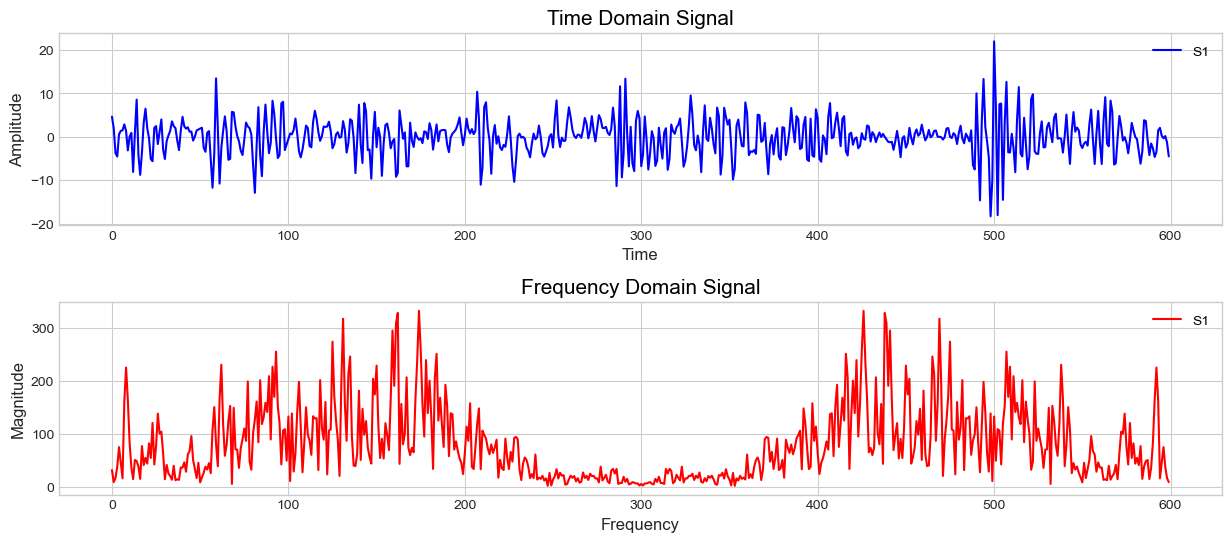

In [31]:
"""Load Data"""
df = Load_data("./data")
df = correct_datatype(df)

"""Seperating the dataset on the basis of Fault, i.e. Healthy and broken."""
df_health = df[df["Fault"] == 0]

data = df_health[df_health["Load_percent"] == 0]
data = data[:600]
data = data.reset_index().drop(["index"], axis = 1)

fft = FFT(data)

plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')

## Add space between subplots
plt.subplots_adjust(hspace=0.5)
fig, (ax1,ax2) = plt.subplots(nrows=2 , figsize=(15, 6))

fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax1.plot(data["S1"], label = "S1", color = "blue")
ax1.set_xlabel("Time")
ax1.set_ylabel("Amplitude")
ax1.set_title("Time Domain Signal", fontsize = 15, color='black')
ax1.legend( loc='upper right', labelcolor='black')

ax2.plot(fft["S1"], label = "S1", color = "red")
ax2.set_xlabel("Frequency")
ax2.set_ylabel("Magnitude")
ax2.set_title("Frequency Domain Signal", fontsize = 15, color='black')
ax2.legend( labelcolor = "black")    

### Processing

In [153]:
"""Load Data"""
df = Load_data("./data")
df = correct_datatype(df)

"""Seperating the dataset on the basis of Fault, i.e. Healthy and broken."""
df_health = df[df["Fault"] == 0]
df_broken = df[df["Fault"] == 1]

In [154]:
df_health[df_health["Load_percent"] == 0].where(df_health["Fault"] == 0).count()

S1              88200
S2              88200
S3              88200
S4              88200
Fault           88200
Freq            88200
Load_percent    88200
dtype: int64

In [155]:
"""Code 4 """
health_data = Feature_create(df_health)
health_data = health_data.reset_index().drop(["index"], axis=1) ## Reset the index in order to concat.
broken_data = Feature_create(df_broken)
broken_data = broken_data.reset_index().drop(["index"], axis=1) ## Reset the index in order to concat.

In [157]:
load_data = pd.DataFrame(pd.DataFrame([[n]*294 for n in np.arange(0,100,10)]).values.flatten(), columns= ["Load"])

In [158]:
"""Concating Load_percentage and Fault data with the healthy and broken dataset"""

healthy = pd.concat([health_data, load_data], axis = 1)
broken = pd.concat([broken_data, load_data], axis = 1)

healthy["Fault"] = [0]*healthy.shape[0]
broken["Fault"] = [1]*broken.shape[0]

In [175]:
final_data = pd.concat([healthy, broken], axis = 0)
final_data = final_data.reset_index().drop(["index"], axis=1)

In [176]:
final_data

S1_F1       S1_F2       S1_F3       S1_F4       S1_F5       S1_F6  \
0     67.588114   83.274424   89.333050  121.477569  162.415101  182.838358   
1     51.920103   70.251762   89.979642  122.138222  158.690533  180.149197   
2     65.583934   84.550627   92.836348  126.160037  176.341143  189.389240   
3     80.441872   85.546588   96.707123  114.467413  195.486409  214.458322   
4     50.654862   65.219061   83.301975  137.704902  179.048342  199.471502   
...         ...         ...         ...         ...         ...         ...   
5875  82.145167   98.950394  203.183440  259.909067  267.102349  268.118957   
5876  92.232201  108.974737  250.392387  391.156171  401.731275  405.256052   
5877  76.841326   89.835878  201.535219  245.366346  255.283510  257.394217   
5878  76.204582  111.970484  270.771741  333.004488  338.851684  341.052721   
5879  75.187397   96.866741  231.100595  265.760746  276.835648  278.394844   

           S1_F7       S1_F8       S1_F9      S1_F10  ...       S4_F8  \
0     218.546804  239.852534  253.000096  265.280810  ...  173.572435   
1     201.690267  225.682263  277.222101  300.708606  ...  160.143979   
2     245.691326  288.321549  333.154596  375.833767  ...  181.657745   
3     235.078857  246.789397  369.131024  389.604178  ...  213.006824   
4     248.377709  266.183094  311.872188  320.815023  ...  172.625035   
...          ...         ...         ...         ...  ...         ...   
5875  269.628699  270.250626  280.398840  284.607669  ...  275.480031   
5876  406.755333  407.541134  417.646438  424.171474  ...  419.868675   
5877  258.652540  260.331457  275.211753  286.061397  ...  351.594198   
5878  341.845281  342.323555  344.846097  347.912208  ...  297.039405   
5879  280.220269  280.804104  296.424179  303.451502  ...  381.644733   

           S4_F9      S4_F10      S4_F11      S4_F12      S4_F13      S4_F14  \
0     175.295666  176.191069  185.517840  187.536514  188.192384  188.461354   
1     162.942691  164.470262  166.298464  169.680096  170.173318  170.492845   
2     184.443174  189.387762  196.750294  205.404570  210.133893  210.633146   
3     218.410803  220.534957  227.241841  230.573960  230.925187  231.236101   
4     176.899814  177.922816  185.769808  188.740185  189.222100  191.066769   
...          ...         ...         ...         ...         ...         ...   
5875  283.127423  284.931213  286.642684  289.148290  289.722393  290.364609   
5876  428.337400  436.987411  440.877766  454.400028  458.815801  459.799754   
5877  370.007285  377.059912  385.265315  396.739673  397.729956  398.195086   
5878  303.925153  305.576480  309.994981  313.859860  314.378283  314.714218   
5879  386.973116  390.555126  392.078700  400.884598  402.765337  403.341430   

          S4_F15  Load  Fault  
0     188.687095     0      0  
1     171.305015     0      0  
2     211.949242     0      0  
3     231.981461     0      0  
4     191.730304     0      0  
...          ...   ...    ...  
5875  290.577407    90      1  
5876  460.118989    90      1  
5877  399.872200    90      1  
5878  315.120806    90      1  
5879  404.490165    90      1  

[5880 rows x 62 columns]

In [178]:
# final_data[['S1_F1', 'S1_F2', 'S1_F3', 'S1_F4', 'S1_F5', 'S1_F6', 'S1_F7', 'S1_F8',
#        'S1_F9', 'S1_F10', 'S1_F11', 'S1_F12', 'S1_F13', 'S1_F14', 'S1_F15',
#        'S2_F1', 'S2_F2', 'S2_F3', 'S2_F4', 'S2_F5', 'S2_F6', 'S2_F7', 'S2_F8',
#        'S2_F9', 'S2_F10', 'S2_F11', 'S2_F12', 'S2_F13', 'S2_F14', 'S2_F15',
#        'S3_F1', 'S3_F2', 'S3_F3', 'S3_F4', 'S3_F5', 'S3_F6', 'S3_F7', 'S3_F8',
#        'S3_F9', 'S3_F10', 'S3_F11', 'S3_F12', 'S3_F13', 'S3_F14', 'S3_F15',
#        'S4_F1', 'S4_F2', 'S4_F3', 'S4_F4', 'S4_F5', 'S4_F6', 'S4_F7', 'S4_F8',
#        'S4_F9', 'S4_F10', 'S4_F11', 'S4_F12', 'S4_F13', 'S4_F14', 'S4_F15']] = final_data[['S1_F1', 'S1_F2', 'S1_F3', 'S1_F4', 'S1_F5', 'S1_F6', 'S1_F7', 'S1_F8',
#        'S1_F9', 'S1_F10', 'S1_F11', 'S1_F12', 'S1_F13', 'S1_F14', 'S1_F15',
#        'S2_F1', 'S2_F2', 'S2_F3', 'S2_F4', 'S2_F5', 'S2_F6', 'S2_F7', 'S2_F8',
#        'S2_F9', 'S2_F10', 'S2_F11', 'S2_F12', 'S2_F13', 'S2_F14', 'S2_F15',
#        'S3_F1', 'S3_F2', 'S3_F3', 'S3_F4', 'S3_F5', 'S3_F6', 'S3_F7', 'S3_F8',
#        'S3_F9', 'S3_F10', 'S3_F11', 'S3_F12', 'S3_F13', 'S3_F14', 'S3_F15',
#        'S4_F1', 'S4_F2', 'S4_F3', 'S4_F4', 'S4_F5', 'S4_F6', 'S4_F7', 'S4_F8',
#        'S4_F9', 'S4_F10', 'S4_F11', 'S4_F12', 'S4_F13', 'S4_F14', 'S4_F15']].astype('float32')
# final_data['Fault'] = final_data['Fault'].astype('int8')
# final_data['Load'] = final_data['Load'].astype('int8')

In [182]:
final_data.to_parquet("Processed_data.parquet", index= False)